In [94]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [182]:
n50 = pd.read_csv('../data/diff_exp/DE_N250.csv', index_col=0)
n58 = pd.read_csv('../data/diff_exp/DE_N258.csv', index_col=0)

detected_n50 = len(n50)
detected_n58 = len(n58)
DE_n50 = (n50.padj <= 0.05).sum()
DE_n58 = (n58.padj <= 0.05).sum()

ens = pd.read_csv('../ensembl.tsv', sep='\t')
df = pd.read_excel('../data/mmc1.xls')  # supplementary data from Tapper et al
df.columns = ['Rank', 'Transcript', 'Gene', 'Locus', 'ensembl_gene_id', 'AvailableExperiments',
              'ExpUp', 'ExpDown', 'VoteScore', 'tvalue', 'pvalue', 'fdr', 'DBE', 'DAE', 'daf16', 'pqm1']

common = np.intersect1d(n50.index, n58.index)

n50 = n50.reindex(common)
n58 = n58.reindex(common)
ens = ens[ens.ensembl_gene_id.isin(common)]

res = n50.join(n58, rsuffix=('_58'), lsuffix=('_50'))
res = res.join(ens.set_index('ensembl_gene_id').drop(columns='ensembl_transcript_id').drop_duplicates())
res = res.join(df.set_index('ensembl_gene_id'), rsuffix='_tapper')

res['Size'] = (res.start_position - res.end_position).abs()


# ignore mito genes:
res = res[res.chromosome_name != 'MtDNA']

def sign(x):
    if x.log2FoldChange_50 * x.log2FoldChange_58 < 0:
        return 'Different'
    else:
        return 'Same'

color = lambda x: 'Positive' if x > 0 else 'Negative'
sig = lambda x: 'DE at 58hrs' if (x.padj_58 < 0.05) else ('DE at 50hrs' if (x.padj_50 < 0.05) else 'Not Sig')

res['SignAt50'] = res.log2FoldChange_50.map(color)
res['SignAt58'] = res.log2FoldChange_58.map(color)

cat_type = pd.CategoricalDtype(categories=['Same', 'Different'], ordered=True)
res['Sign'] = res.apply(sign, axis=1).astype(cat_type)

cat_type = pd.CategoricalDtype(categories=['Not Sig', 'DE at 50hrs', 'DE at 58hrs'], ordered=True)
res['Significance'] = res.apply(sig, axis=1).astype(cat_type)

res['Ratio'] = (res.log2FoldChange_58) / res.log2FoldChange_50
res['Above'] = res.Ratio.apply(lambda x: True if x > 3 else False)


print('Detected:', detected_n50, detected_n58)
print('DE:', DE_n50, DE_n58)
print('Commonly found: ', len(common))
print('DE after subsetting: ', (res.padj_50 < 0.05).sum(), (res.padj_58 < 0.05).sum())
print('DE after subsetting and discarding different directions', ((res.padj_50 < 0.05) & (res.Sign == 'Same')).sum(),
      ((res.padj_58 < 0.05) & (res.Sign == 'Same')).sum())

Detected: 16021 15461
DE: 1756 610
Commonly found:  14972
DE after subsetting:  1742 587
DE after subsetting and discarding different directions 1473 487


In [118]:
res.to_csv('../data/master_table.tsv', sep='\t')

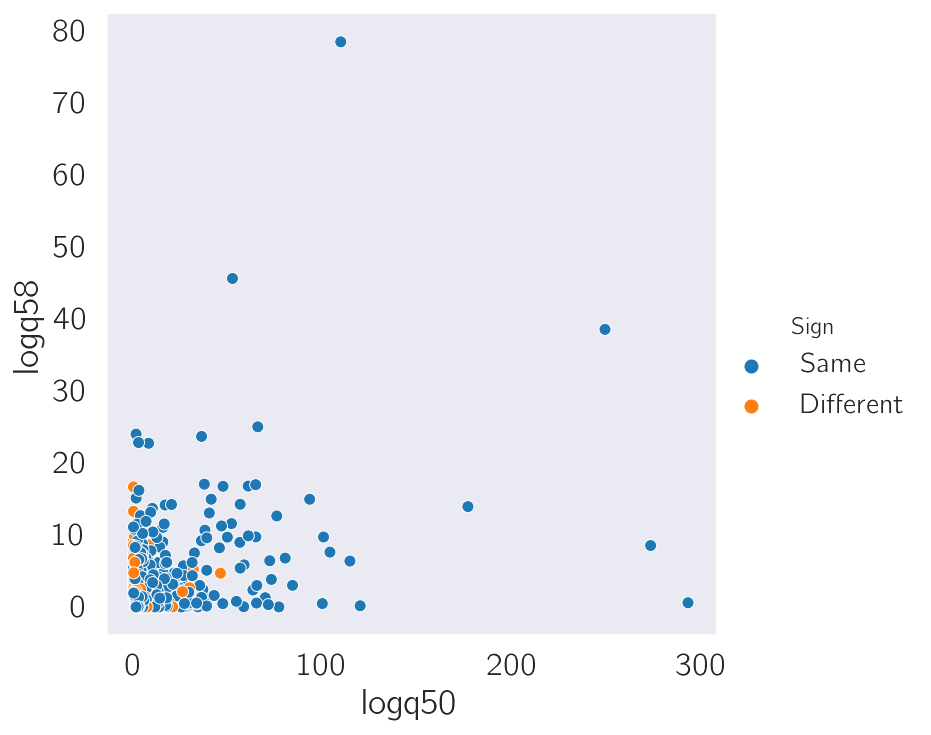

In [119]:
res = res[(res.padj_50 < 0.05) | (res.padj_58 < 0.05)]

sns.relplot(
    data=res.rename(columns={'chromosome_name': 'chromosome',
                             'logq_50': 'logq50',
                             'logq_58': 'logq58'}),
    x="logq50", y="logq58",
    kind="scatter", hue='Sign',
)

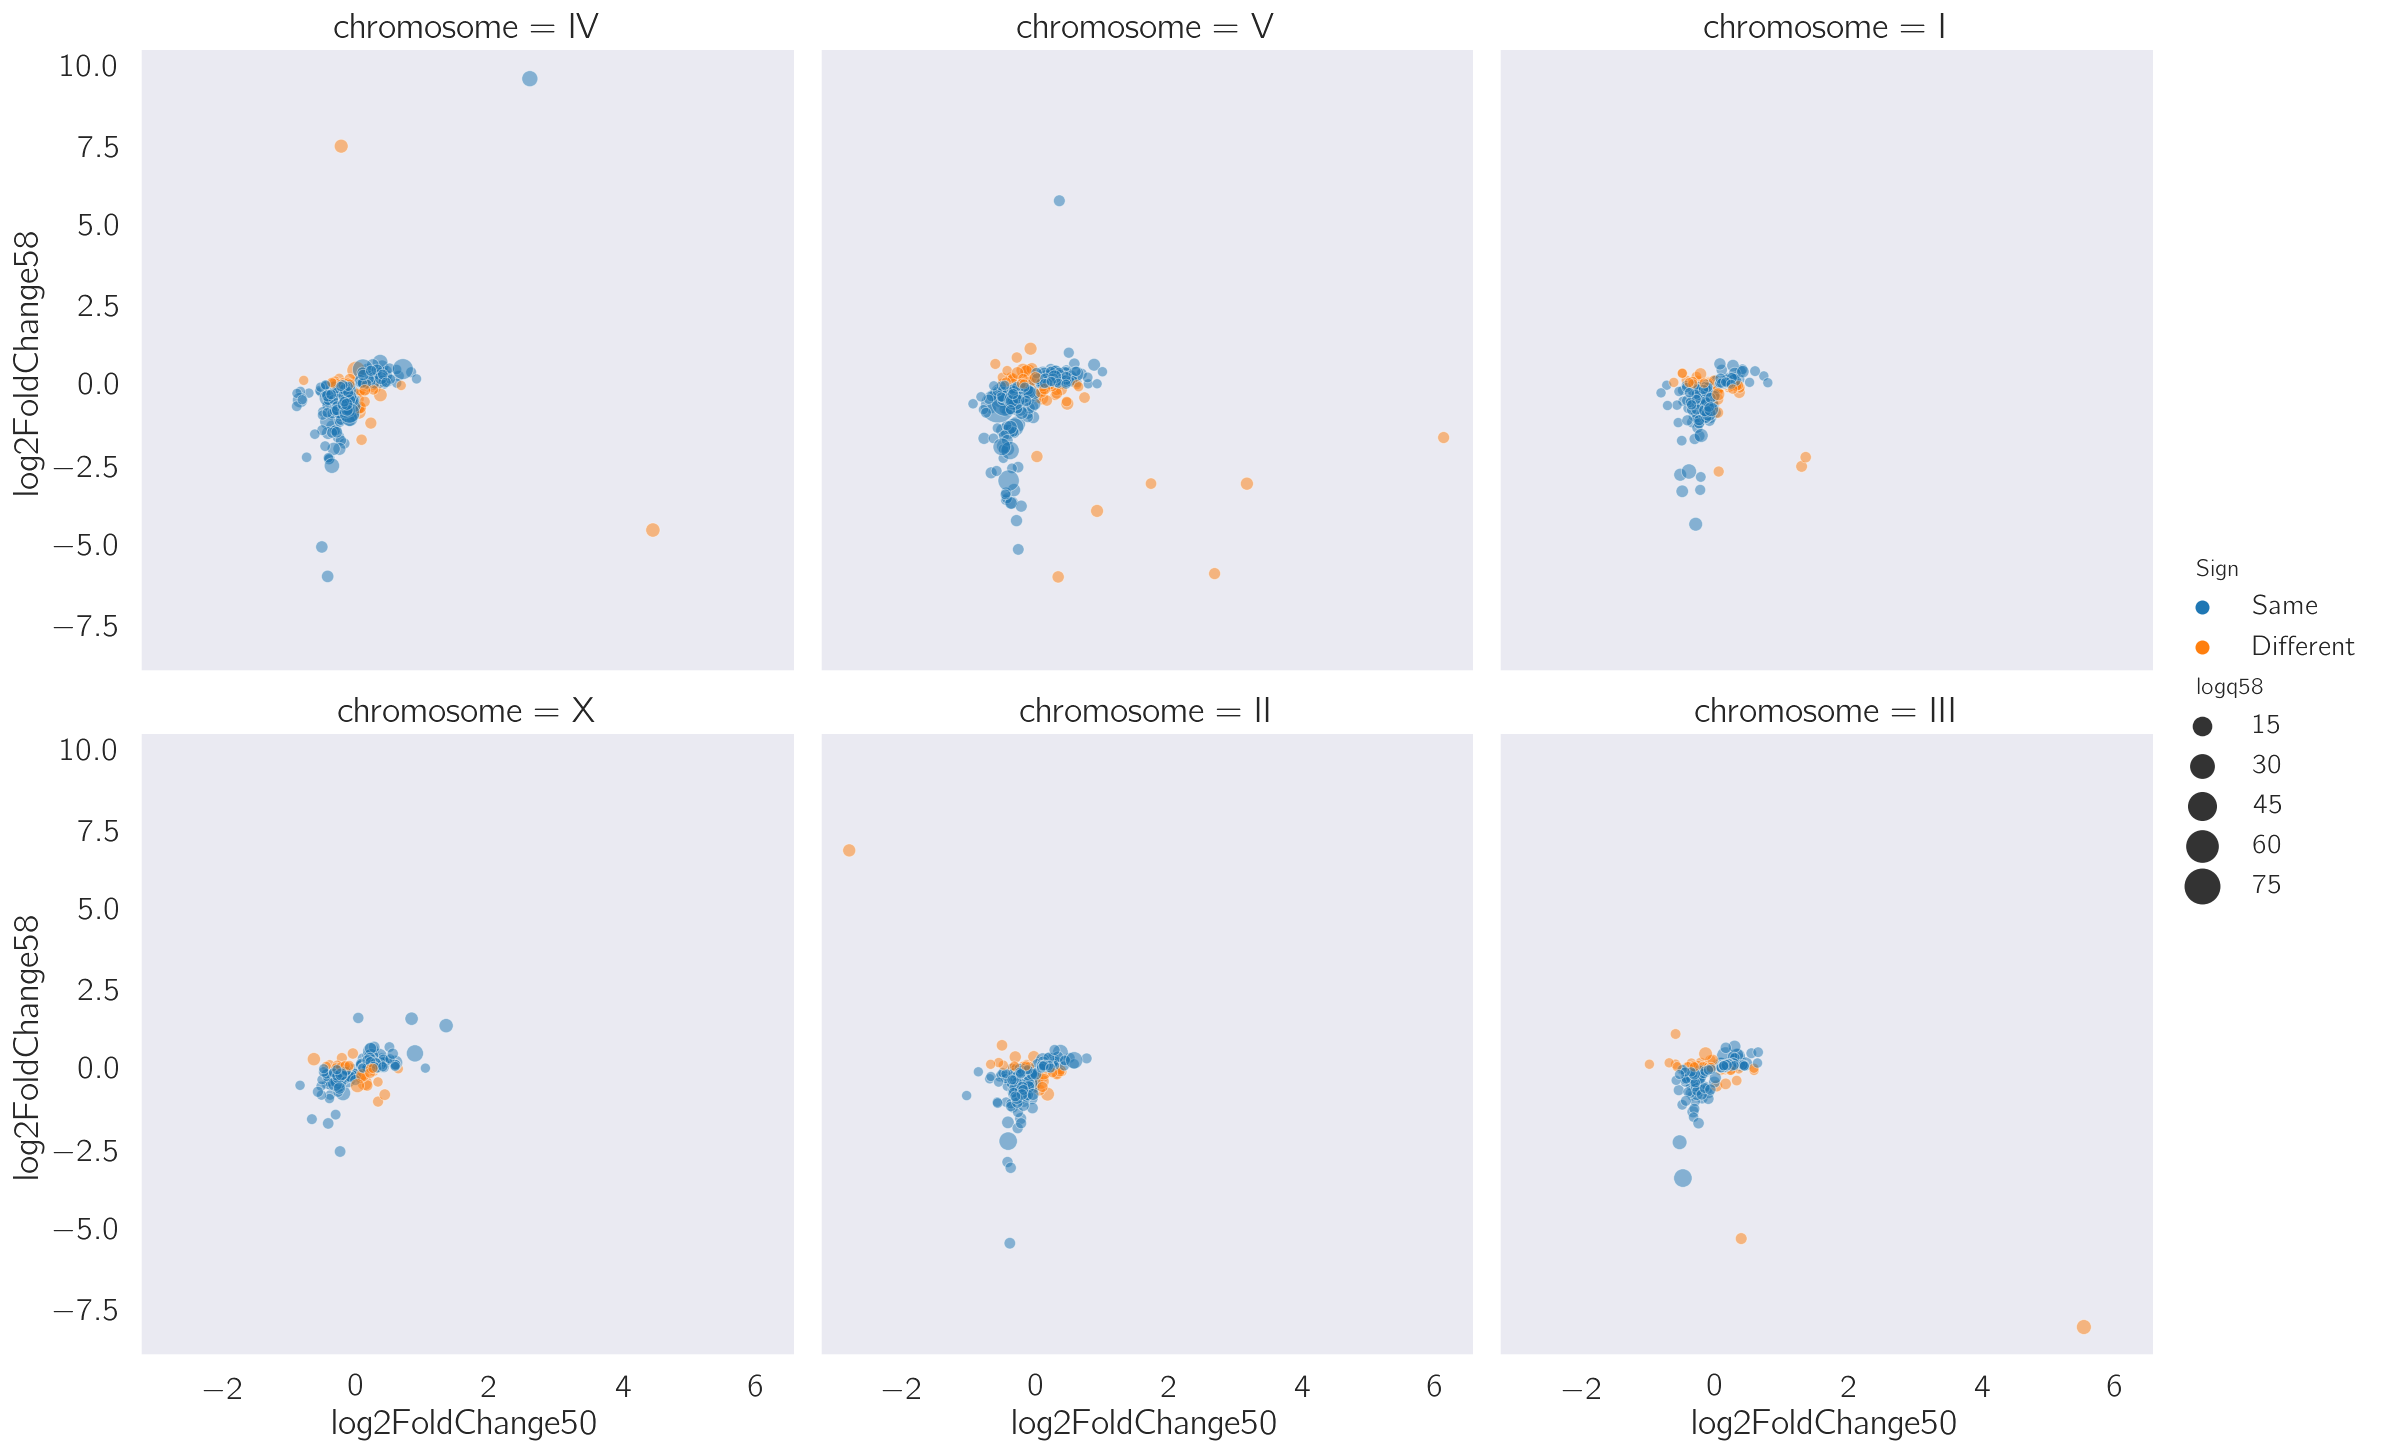

In [120]:
sns.relplot(
    data=res.rename(columns={'chromosome_name': 'chromosome',
                             'log2FoldChange_50': 'log2FoldChange50',
                             'log2FoldChange_58': 'log2FoldChange58',
                             'logq_58': 'logq58'
                            }),
    x="log2FoldChange50", y="log2FoldChange58",
    col="chromosome", size='logq58', col_wrap=3,
    kind="scatter", sizes=(25, 300), hue='Sign',
    alpha=0.5
)

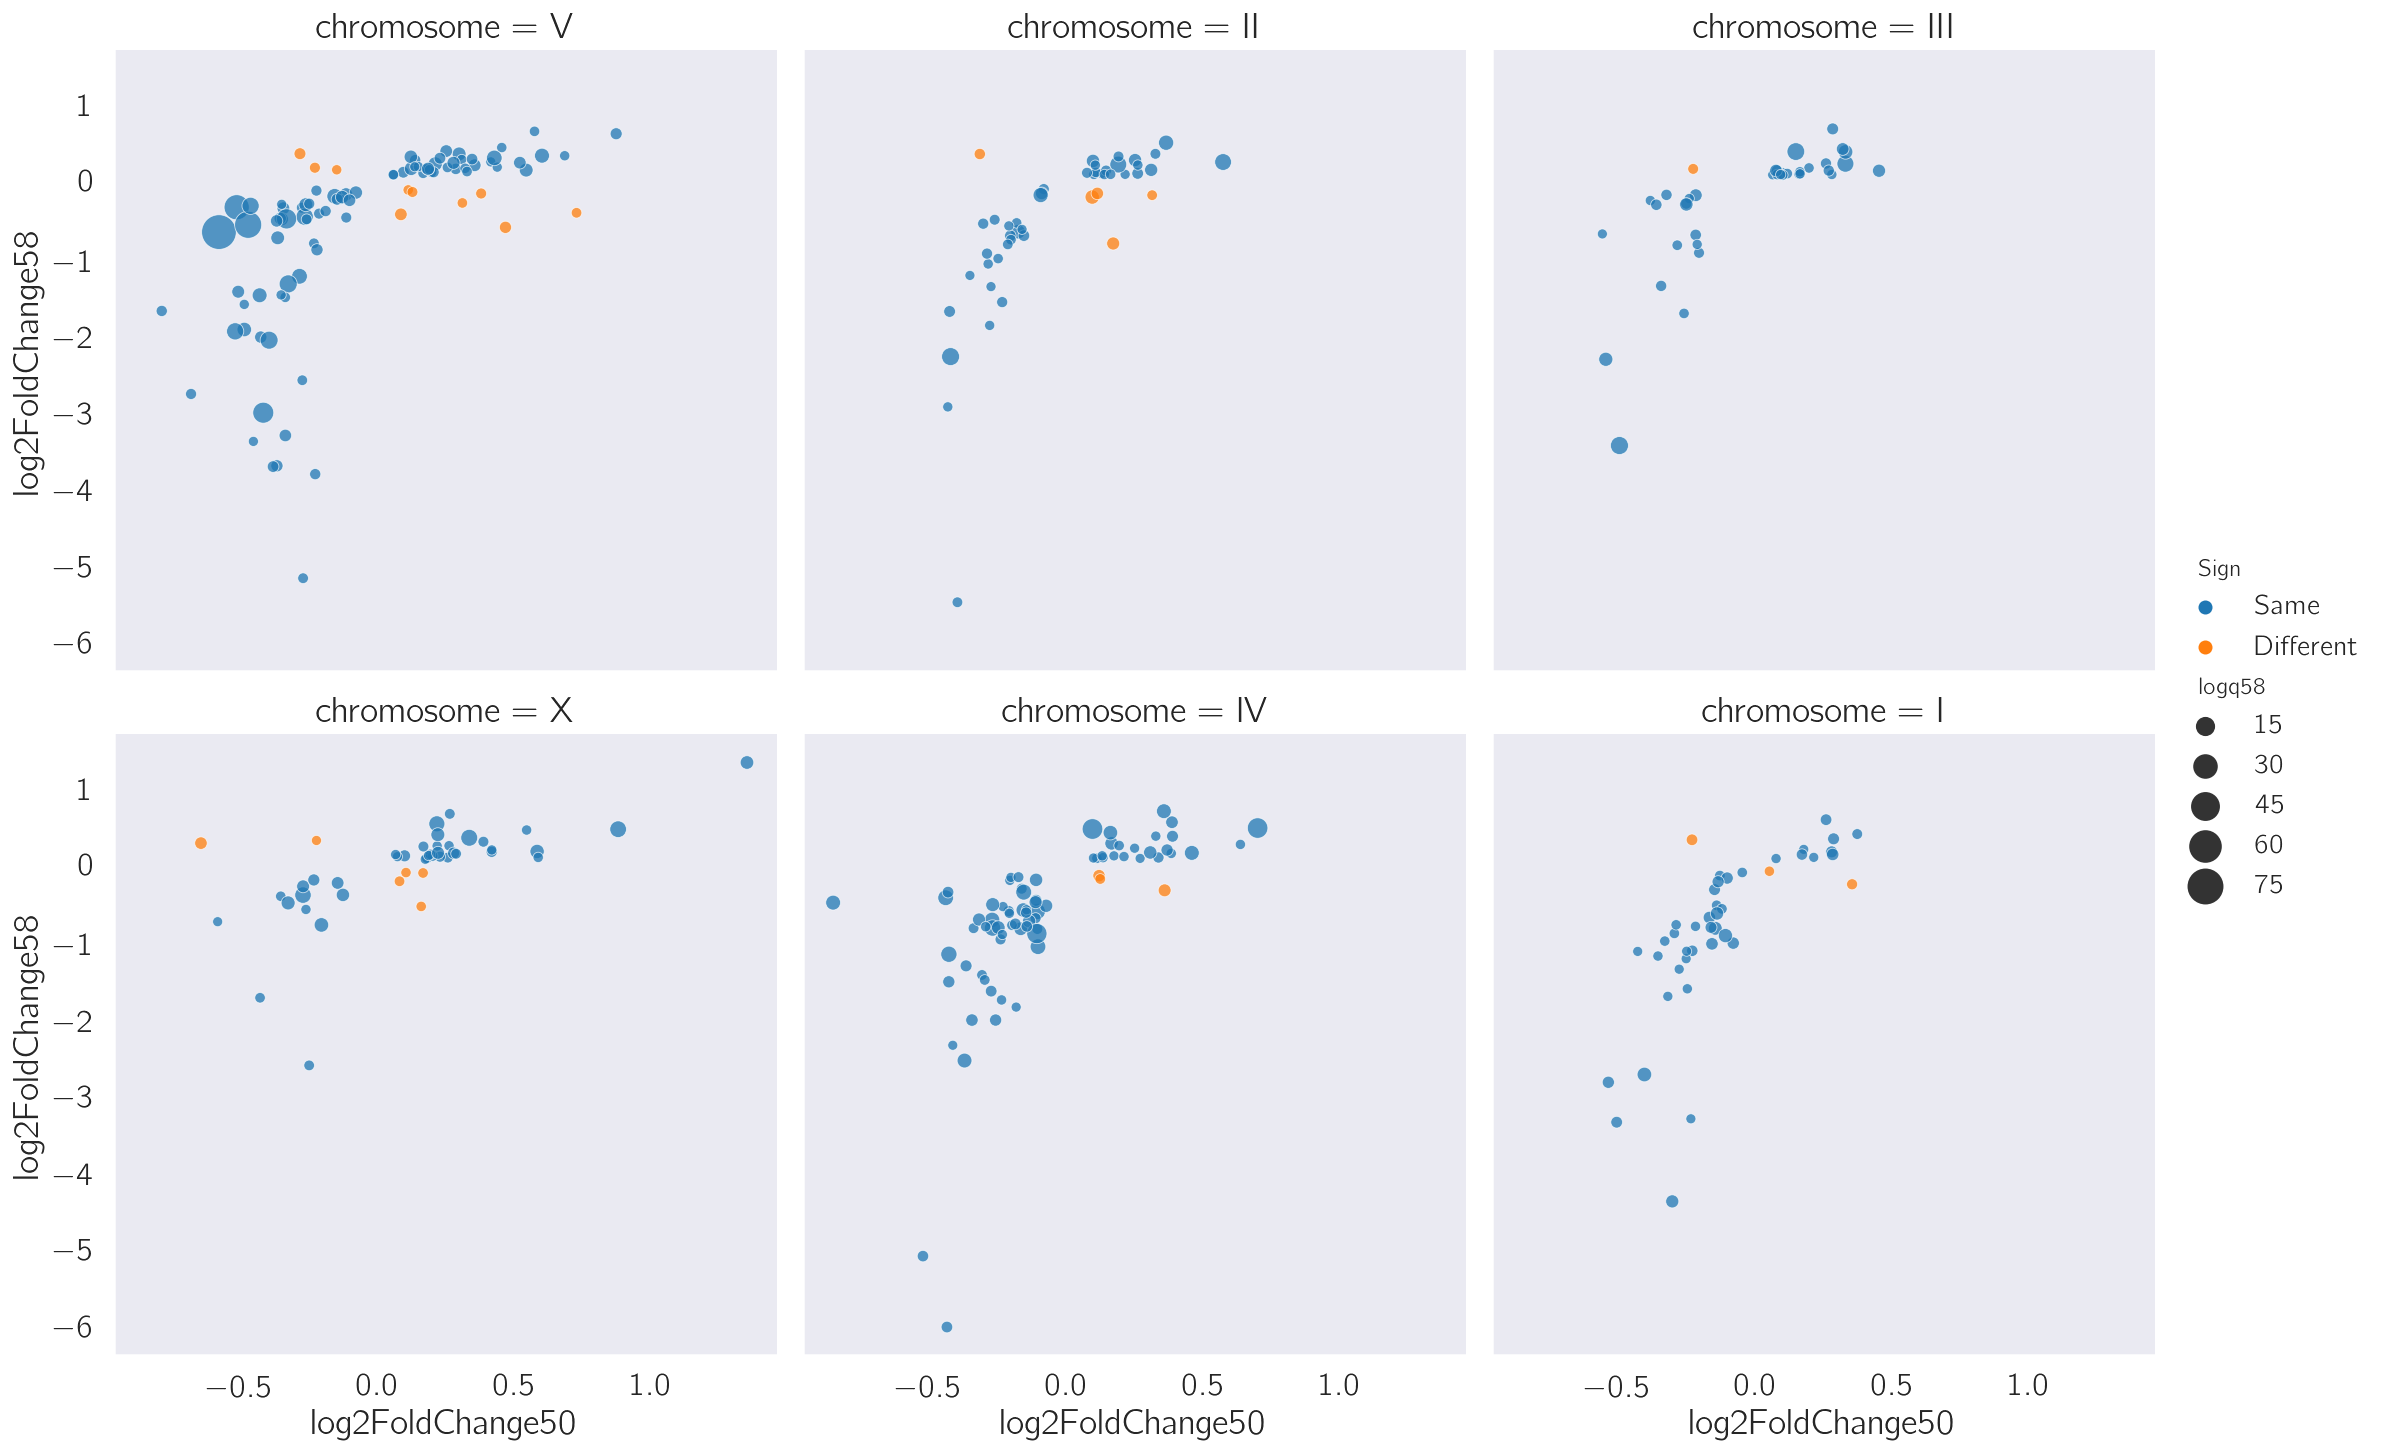

In [121]:
sns.relplot(
    data=res[(res.padj_58 < 0.05) & (res.padj_50 < 0.05)].rename(columns={'chromosome_name': 'chromosome',
                                                                          'log2FoldChange_50': 'log2FoldChange50',
                                                                          'log2FoldChange_58': 'log2FoldChange58',
                                                                          'logq_58': 'logq58'
                                                                         }),
    x="log2FoldChange50", y="log2FoldChange58",
    col="chromosome", size='logq58', col_wrap=3,
    kind="scatter", sizes=(25, 300), hue='Sign',
    alpha=0.75
)

(-6.0, 2.5)

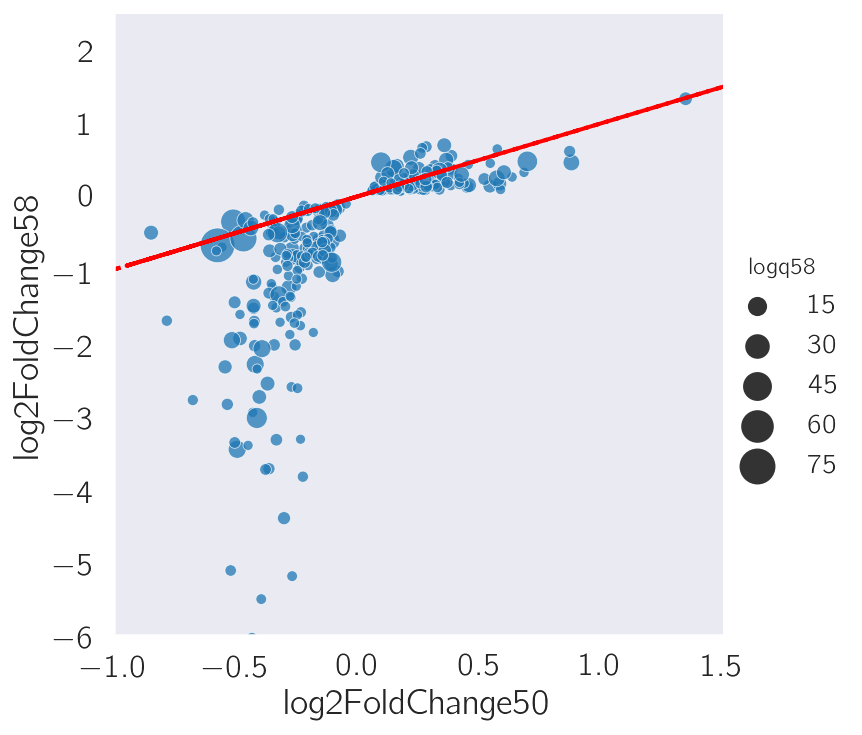

In [124]:
res = res[res.Sign == 'Same']

sig = (res.padj_58 < 0.05) & (res.padj_50 < 0.05)

sns.relplot(
    data=res[sig].rename(columns={'chromosome_name': 'chromosome',
                                  'log2FoldChange_50': 'log2FoldChange50',
                                  'log2FoldChange_58': 'log2FoldChange58',
                                  'logq_58': 'logq58'
                                 }),
    x="log2FoldChange50", y="log2FoldChange58",
    size='logq58',
    kind="scatter", sizes=(25, 300),# hue='Significance',
    alpha=0.75
)

plt.plot(res.log2FoldChange_50, 1 * res.log2FoldChange_50,
         label='50hrs = 58hrs', color='red', ls='--')
plt.xlim(-1, 1.5)
plt.ylim(-6, 2.5)
# plt.legend()

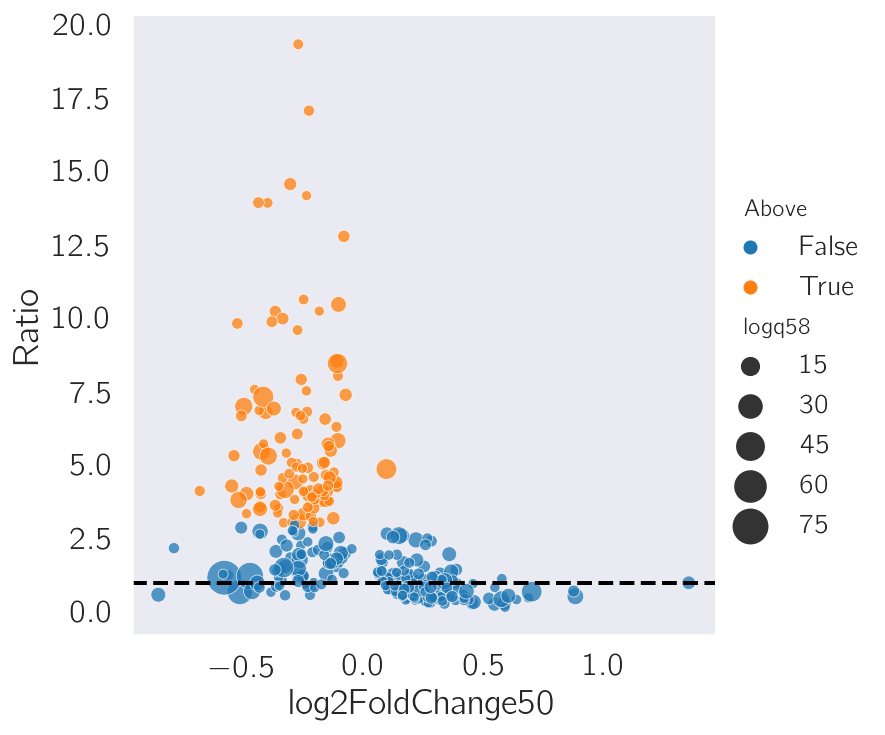

In [125]:
sig = (res.padj_58 < 0.05) & (res.padj_50 < 0.05)

sns.relplot(
    data=res[(sig)].rename(columns={'chromosome_name': 'chromosome',
                                    'log2FoldChange_50': 'log2FoldChange50',
                                    'log2FoldChange_58': 'log2FoldChange58',
                                    'logq_58': 'logq58'
                                   }),
    x="log2FoldChange50", y="Ratio",
    size='logq58',
    kind="scatter", sizes=(25, 300), hue='Above',
    alpha=0.75
)

plt.axhline(1, color='black', ls='--')

In [168]:
whale = pd.crosstab(res.chromosome_name, res.Above, margins=True)

In [169]:
whale

Above,False,True,All
chromosome_name,,,
I,223,56,279
II,202,48,250
III,223,20,243
IV,277,74,351
V,268,48,316
X,187,13,200
All,1380,259,1639


In [170]:
whale = pd.DataFrame(whale)
whale.columns = ['F', 'Tr', 'All']
whale['pval'] = whale.apply(lambda x: np.min([1, scipy.stats.hypergeom.sf(x.Tr, whale['All'].reindex(['All'])[0],
                                                                          x['All'], whale.Tr.reindex(['All'])[0]) * 6]),
                            axis=1)
whale[whale.pval < 0.05]

,F,Tr,All,pval
chromosome_name,,,,
IV,277,74,351,0.006606
All,1380,259,1639,0.000000


In [180]:
res[sig & (res.Above)][['external_gene_name', 'log2FoldChange_58']].sort_values('external_gene_name').tail(50)

,external_gene_name,log2FoldChange_58
WBGene00006449,alg-4,-0.705792
WBGene00010485,ant-1.3,-0.912197
WBGene00007248,catp-4,-0.549174
WBGene00000681,col-107,-1.321703
WBGene00000683,col-109,-1.860477
WBGene00000601,col-12,-1.246467
WBGene00000694,col-120,-1.767059
WBGene00000704,col-130,-1.529851
WBGene00000707,col-133,-0.826991
WBGene00000603,col-14,-1.651896
